(mccall_with_sep)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Job Search II: Search and Separation

```{index} single: An Introduction to Job Search
```

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

## Overview

Previously {doc}`we looked <mccall_model>` at the McCall job search model {cite}`McCall1970` as a way of understanding unemployment and worker decisions.

One unrealistic feature of the model is that every job is permanent.

In this lecture, we extend the McCall model by introducing job separation.

Once separation enters the picture, the agent comes to view

* the loss of a job as a capital loss, and
* a spell of unemployment as an *investment* in searching for an acceptable job

The other minor addition is that a utility function will be included to make
worker preferences slightly more sophisticated.

We'll need the following imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import njit, float64
from numba.experimental import jitclass
from quantecon.distributions import BetaBinomial

## The Model

The model is similar to the {doc}`baseline McCall job search model <mccall_model>`.

It concerns the life of an infinitely lived worker and

* the opportunities he or she (let's say he to save one character) has to work at different wages
* exogenous events that destroy his current job
* his decision making process while unemployed

The worker can be in one of two states: employed or unemployed.

He wants to maximize

```{math}
:label: objective

{\mathbb E} \sum_{t=0}^\infty \beta^t u(y_t)
```

At this stage the only difference from the {doc}`baseline model <mccall_model>` is that we've added some flexibility to preferences by
introducing a utility function $u$.

It satisfies $u'> 0$ and $u'' < 0$.

### The Wage Process

For now we will drop the separation of state process and wage process that we
maintained for the {doc}`baseline model <mccall_model>`.

In particular, we simply suppose that wage offers $\{ w_t \}$ are IID with common distribution $q$.

The set of possible wage values is denoted by $\mathbb W$.

(Later we will go back to having a separate state process $\{s_t\}$
driving random outcomes, since this formulation is usually convenient in more sophisticated
models.)

### Timing and Decisions

At the start of each period, the agent can be either

* unemployed or
* employed at some existing wage level $w_e$.

At the start of a given period, the current wage offer $w_t$ is observed.

If currently *employed*, the worker

1. receives utility $u(w_e)$ and
1. is fired with some (small) probability $\alpha$.

If currently *unemployed*, the worker either accepts or rejects the current offer $w_t$.

If he accepts, then he begins work immediately at wage $w_t$.

If he rejects, then he receives unemployment compensation $c$.

The process then repeats.

(Note: we do not allow for job search while employed---this topic is taken up in a {doc}`later lecture <jv>`.)

## Solving the Model

We drop time subscripts in what follows and primes denote next period values.

Let

* $v(w_e)$ be total lifetime value accruing to a worker who enters the current period *employed* with existing wage $w_e$
* $h(w)$ be total lifetime value accruing to a worker who who enters the current period *unemployed* and receives
  wage offer $w$.

Here *value* means the value of the objective function {eq}`objective` when the worker makes optimal decisions at all future points in time.

Our first aim is to obtain these functions.

### The Bellman Equations

Suppose for now that the worker can calculate the functions $v$ and $h$ and use them in his decision making.

Then $v$ and $h$  should satisfy

```{math}
:label: bell1_mccall

v(w_e) = u(w_e) + \beta
    \left[
        (1-\alpha)v(w_e) + \alpha \sum_{w' \in \mathbb W} h(w') q(w')
    \right]
```

and

```{math}
:label: bell2_mccall

h(w) = \max \left\{ v(w), \,  u(c) + \beta \sum_{w' \in \mathbb W} h(w') q(w') \right\}
```

Equation {eq}`bell1_mccall` expresses the value of being employed at wage $w_e$ in terms of

* current reward $u(w_e)$ plus
* discounted expected reward tomorrow, given the $\alpha$ probability of being fired

Equation {eq}`bell2_mccall` expresses the value of being unemployed with offer
$w$ in hand as a maximum over the value of two options: accept or reject
the current offer.

Accepting transitions the worker to employment and hence yields reward $v(w)$.

Rejecting leads to unemployment compensation and unemployment tomorrow.

Equations {eq}`bell1_mccall` and {eq}`bell2_mccall` are the Bellman equations for this model.

They provide enough information to solve for both $v$ and $h$.

(ast_mcm)=
### A Simplifying Transformation

Rather than jumping straight into solving these equations, let's see if we can
simplify them somewhat.

(This process will be analogous to our {ref}`second pass <mm_op2>` at the plain vanilla
McCall model, where we simplified the Bellman equation.)

First, let

```{math}
:label: defd_mm

d := \sum_{w' \in \mathbb W} h(w') q(w')
```

be the expected value of unemployment tomorrow.

We can now write {eq}`bell2_mccall` as

$$
h(w) = \max \left\{ v(w), \,  u(c) + \beta d \right\}
$$

or, shifting time forward one period

$$
\sum_{w' \in \mathbb W} h(w') q(w')
 = \sum_{w' \in \mathbb W} \max \left\{ v(w'), \,  u(c) + \beta d \right\} q(w')
$$

Using {eq}`defd_mm` again now gives

```{math}
:label: bell02_mccall

d = \sum_{w' \in \mathbb W} \max \left\{ v(w'), \,  u(c) + \beta d \right\} q(w')
```

Finally, {eq}`bell1_mccall` can now be rewritten as

```{math}
:label: bell01_mccall

v(w) = u(w) + \beta
    \left[
        (1-\alpha)v(w) + \alpha d
    \right]
```

In the last expression, we wrote $w_e$ as $w$ to make the notation
simpler.

### The Reservation Wage

Suppose we can use {eq}`bell02_mccall` and {eq}`bell01_mccall` to solve for
$d$ and $v$.

(We will do this soon.)

We can then determine optimal behavior for the worker.

From {eq}`bell2_mccall`, we see that an unemployed agent accepts current offer
$w$ if $v(w) \geq  u(c) + \beta d$.

This means precisely that the value of accepting is higher than the expected value of rejecting.

It is clear that $v$ is (at least weakly) increasing in $w$, since the agent is never made worse off by a higher wage offer.

Hence, we can express the optimal choice as accepting wage offer $w$ if and only if

$$
w \geq \bar w
\quad \text{where} \quad
\bar w \text{ solves } v(\bar w) =  u(c) + \beta d
$$

### Solving the Bellman Equations

We'll use the same iterative approach to solving the Bellman equations that we
adopted in the {doc}`first job search lecture <mccall_model>`.

Here this amounts to

1. make guesses for $d$ and $v$
1. plug these guesses into the right-hand sides of {eq}`bell02_mccall` and {eq}`bell01_mccall`
1. update the left-hand sides from this rule and then repeat

In other words, we are iterating using the rules

```{math}
:label: bell1001

d_{n+1} = \sum_{w' \in \mathbb W}
    \max \left\{ v_n(w'), \,  u(c) + \beta d_n \right\} q(w')
```

```{math}
:label: bell2001

v_{n+1}(w) = u(w) + \beta
    \left[
        (1-\alpha)v_n(w) + \alpha d_n
    \right]
```

starting from some initial conditions $d_0, v_0$.

As before, the system always converges to the true solutions---in this case,
the $v$ and $d$ that solve {eq}`bell02_mccall` and {eq}`bell01_mccall`.

(A proof can be obtained via the Banach contraction mapping theorem.)

## Implementation

Let's implement this iterative process.

In the code, you'll see that we use a class to store the various parameters and other
objects associated with a given model.

This helps to tidy up the code and provides an object that's easy to pass to functions.

The default utility function is a CRRA utility function

In [3]:
@njit
def u(c, σ=2.0):
    return (c**(1 - σ) - 1) / (1 - σ)

Also, here's a default wage distribution, based around the BetaBinomial
distribution:

In [4]:
n = 60                                  # n possible outcomes for w
w_default = np.linspace(10, 20, n)      # wages between 10 and 20
a, b = 600, 400                         # shape parameters
dist = BetaBinomial(n-1, a, b)
q_default = dist.pdf()

Here's our jitted class for the McCall model with separation.

In [5]:
mccall_data = [
    ('α', float64),      # job separation rate
    ('β', float64),      # discount factor
    ('c', float64),      # unemployment compensation
    ('w', float64[:]),   # list of wage values
    ('q', float64[:])    # pmf of random variable w
]

@jitclass(mccall_data)
class McCallModel:
    """
    Stores the parameters and functions associated with a given model.
    """

    def __init__(self, α=0.2, β=0.98, c=6.0, w=w_default, q=q_default):

        self.α, self.β, self.c, self.w, self.q = α, β, c, w, q


    def update(self, v, d):

        α, β, c, w, q = self.α, self.β, self.c, self.w, self.q

        v_new = np.empty_like(v)

        for i in range(len(w)):
            v_new[i] = u(w[i]) + β * ((1 - α) * v[i] + α * d)

        d_new = np.sum(np.maximum(v, u(c) + β * d) * q)

        return v_new, d_new

Now we iterate until successive realizations are closer together than some small tolerance level.

We then return the current iterate as an approximate solution.

In [6]:
@njit
def solve_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    * mcm is an instance of McCallModel
    """

    v = np.ones_like(mcm.w)    # Initial guess of v
    d = 1                      # Initial guess of d
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        v_new, d_new = mcm.update(v, d)
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(d_new - d)
        error = max(error_1, error_2)
        v = v_new
        d = d_new
        i += 1

    return v, d

### The Reservation Wage: First Pass

The optimal choice of the agent is summarized by the reservation wage.

As discussed above, the reservation wage is the $\bar w$ that solves
$v(\bar w) = h$ where $h := u(c) + \beta d$ is the continuation
value.

Let's compare $v$ and $h$ to see what they look like.

We'll use the default parameterizations found in the code above.

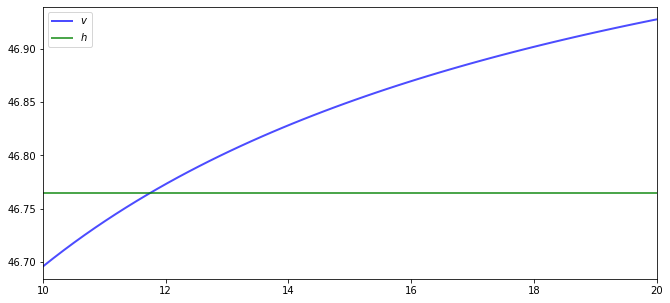

In [7]:
mcm = McCallModel()
v, d = solve_model(mcm)
h = u(mcm.c) + mcm.β * d

fig, ax = plt.subplots()

ax.plot(mcm.w, v, 'b-', lw=2, alpha=0.7, label='$v$')
ax.plot(mcm.w, [h] * len(mcm.w),
        'g-', lw=2, alpha=0.7, label='$h$')
ax.set_xlim(min(mcm.w), max(mcm.w))
ax.legend()

plt.show()

The value $v$ is increasing because higher $w$ generates a higher wage flow conditional on staying employed.

### The Reservation Wage: Computation

Here's a function `compute_reservation_wage` that takes an instance of `McCallModel`
and returns the associated reservation wage.

In [8]:
@njit
def compute_reservation_wage(mcm):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that v(w) >= h.

    If no such w exists, then w_bar is set to np.inf.
    """

    v, d = solve_model(mcm)
    h = u(mcm.c) + mcm.β * d

    w_bar = np.inf
    for i, wage in enumerate(mcm.w):
        if v[i] > h:
            w_bar = wage
            break

    return w_bar

Next we will investigate how the reservation wage varies with parameters.

## Impact of Parameters

In each instance below, we'll show you a figure and then ask you to reproduce it in the exercises.

### The Reservation Wage and Unemployment Compensation

First, let's look at how $\bar w$ varies with unemployment compensation.

In the figure below, we use the default parameters in the `McCallModel` class, apart from
c (which takes the values given on the horizontal axis)

```{figure} /_static/lecture_specific/mccall_model_with_separation/mccall_resw_c.png

```

As expected, higher unemployment compensation causes the worker to hold out for higher wages.

In effect, the cost of continuing job search is reduced.

### The Reservation Wage and Discounting

Next, let's investigate how $\bar w$ varies with the discount factor.

The next figure plots the reservation wage associated with different values of
$\beta$

```{figure} /_static/lecture_specific/mccall_model_with_separation/mccall_resw_beta.png

```

Again, the results are intuitive: More patient workers will hold out for higher wages.

### The Reservation Wage and Job Destruction

Finally, let's look at how $\bar w$ varies with the job separation rate $\alpha$.

Higher $\alpha$ translates to a greater chance that a worker will face termination in each period once employed.

```{figure} /_static/lecture_specific/mccall_model_with_separation/mccall_resw_alpha.png

```

Once more, the results are in line with our intuition.

If the separation rate is high, then the benefit of holding out for a higher wage falls.

Hence the reservation wage is lower.

## Exercises

```{exercise-start}
:label: mmws_ex1
```

Reproduce all the reservation wage figures shown above.

Regarding the values on the horizontal axis, use

In [9]:
grid_size = 25
c_vals = np.linspace(2, 12, grid_size)         # unemployment compensation
beta_vals = np.linspace(0.8, 0.99, grid_size)  # discount factors
alpha_vals = np.linspace(0.05, 0.5, grid_size) # separation rate

```{exercise-end}
```

## Solutions

```{solution-start} mmws_ex1
:class: dropdown
```

Here's the first figure.

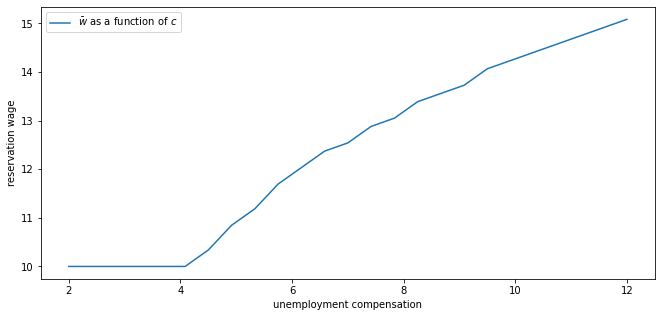

In [10]:
mcm = McCallModel()

w_bar_vals = np.empty_like(c_vals)

fig, ax = plt.subplots()

for i, c in enumerate(c_vals):
    mcm.c = c
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='unemployment compensation',
       ylabel='reservation wage')
ax.plot(c_vals, w_bar_vals, label=r'$\bar w$ as a function of $c$')
ax.legend()

plt.show()

Here's the second one.

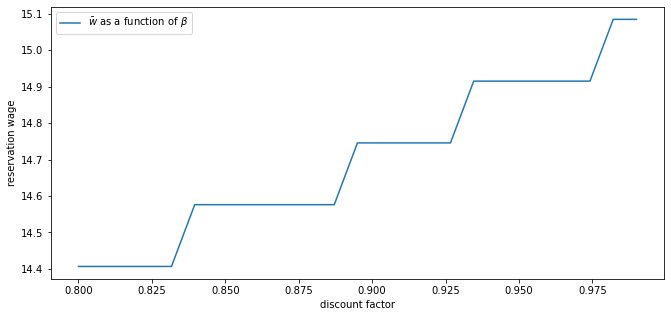

In [11]:
fig, ax = plt.subplots()

for i, β in enumerate(beta_vals):
    mcm.β = β
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='discount factor', ylabel='reservation wage')
ax.plot(beta_vals, w_bar_vals, label=r'$\bar w$ as a function of $\beta$')
ax.legend()

plt.show()

Here's the third.

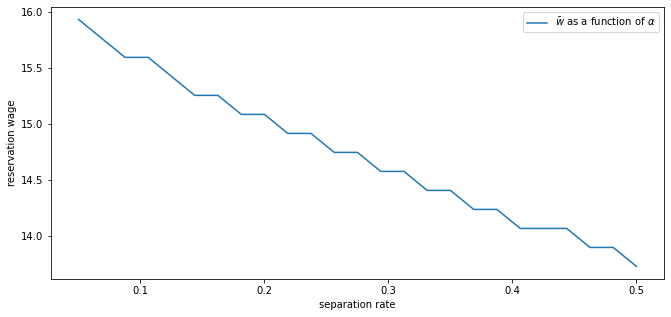

In [12]:
fig, ax = plt.subplots()

for i, α in enumerate(alpha_vals):
    mcm.α = α
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='separation rate', ylabel='reservation wage')
ax.plot(alpha_vals, w_bar_vals, label=r'$\bar w$ as a function of $\alpha$')
ax.legend()

plt.show()

```{solution-end}
```